In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
import optuna
import matplotlib.pyplot as plt


In [114]:
# Function to load and preprocess data
def load_and_preprocess_data(file_path):
    full_data = pd.read_csv(file_path, sep='\t')
    full_data["MAF"] = full_data["EUR_MAF"]
    full_data["lag_MAF"] = full_data["lag_EUR_MAF"]
    full_data["min_MAF"] = full_data["min_EUR_MAF"]
    full_data["diff_MAF"] = full_data["diff_EUR_MAF"]
    
    # Create interaction terms
    full_data["log10distance_intxn_r2"] = full_data["log10_distance"] * full_data["r2"]
    full_data["log10distance_intxn_minMAF"] = full_data["log10_distance"] * full_data["min_MAF"]
    full_data["log10distance_intxn_diffMAF"] = full_data["log10_distance"] * full_data["diff_MAF"]

    full_data_sub = full_data[[
        "chr", "pos", "geneID", "error", "d", "r2", "AF", "MAF", 
        "lag_MAF", "min_MAF", "diff_MAF", "log10_distance",
        "log10distance_intxn_r2", "log10distance_intxn_minMAF", 
        "log10distance_intxn_diffMAF"
    ]]
    
    filtered_df = full_data_sub.groupby('geneID').apply(
        lambda x: x.sort_values(['chr', 'pos']).iloc[1:]
    ).reset_index(drop=True)
    
    return filtered_df

# Function to split data into train, validation, and test sets
def split_data(data):
    X = data[["d", "r2", "min_MAF", "diff_MAF", "log10_distance", 
              "log10distance_intxn_minMAF", "log10distance_intxn_r2", 
              "log10distance_intxn_diffMAF"]]
    y = data[["error"]]

    X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_final_train, y_final_train, test_size=0.25, random_state=42, stratify=y_final_train
    )

    return (X_train, X_val, X_final_test, y_train, y_val, y_final_test)

# Function to convert DataFrames to PyTorch tensors
def to_tensors(X_train, y_train, X_val, y_val, X_final_test, y_final_test):
    train_features = torch.tensor(X_train.to_numpy()).float()
    train_targets = torch.tensor(y_train.to_numpy()).float().unsqueeze(1)
    val_features = torch.tensor(X_val.to_numpy()).float()
    val_targets = torch.tensor(y_val.to_numpy()).float().unsqueeze(1)
    test_features = torch.tensor(X_final_test.to_numpy()).float()
    test_targets = torch.tensor(y_final_test.to_numpy()).float().unsqueeze(1)

    return (train_features, train_targets, val_features, val_targets, test_features, test_targets)


# Function to create DataLoaders
def create_dataloaders(train_features, train_targets, val_features, val_targets, test_features, test_targets):
    train_dataset = TensorDataset(train_features, train_targets)
    val_dataset = TensorDataset(val_features, val_targets)
    test_dataset = TensorDataset(test_features, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, verbose=False):
    train_losses = []
    train_log_losses = []
    val_losses = []
    val_log_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        # Training loop
        for features, labels in train_loader:
            labels = labels.view(-1, 1)  # Ensure labels are in the correct shape
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate and append training log loss
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            train_probs = torch.sigmoid(model(train_loader.dataset.tensors[0])).detach().cpu().numpy()
            train_labels = train_loader.dataset.tensors[1].detach().cpu().numpy().flatten()
            train_epoch_log_loss = log_loss(train_labels, train_probs)
            train_log_losses.append(train_epoch_log_loss)

        # Validation loss calculation
        total_val_loss = 0.0
        for features, labels in val_loader:
            labels = labels.view(-1, 1)  # Ensure labels are in the correct shape
            outputs = model(features)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate and append validation log loss
        val_probs = torch.sigmoid(model(val_loader.dataset.tensors[0])).detach().cpu().numpy()
        val_labels = val_loader.dataset.tensors[1].detach().cpu().numpy().flatten()
        val_epoch_log_loss = log_loss(val_labels, val_probs)
        val_log_losses.append(val_epoch_log_loss)

        if verbose:
            # Print loss information only if verbose is True
            print(f"Epoch [{epoch + 1}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Train Log Loss: {train_epoch_log_loss:.4f}, "
                  f"Validation Log Loss: {val_epoch_log_loss:.4f}")

    return train_losses, train_log_losses, val_losses, val_log_losses


# Function to evaluate the model
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    probs = []
    labels = []
    
    with torch.no_grad():
        for features, label in data_loader:
            label = label.view(-1, 1)
            output = model(features)
            total_loss += criterion(output, label).item()
            probs.append(torch.sigmoid(output).cpu().numpy())
            labels.append(label.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    probs = np.concatenate(probs)
    labels = np.concatenate(labels)
    
    return avg_loss, probs, labels

def plot_losses(train_losses, val_losses, train_log_losses, val_log_losses, num_epochs):
    plt.figure(figsize=(12, 6))

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training BCElogitLoss', color='tab:blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation BCElogitLoss', color='tab:orange')
    plt.xlabel('Epochs')
    plt.ylabel('BCElogitLoss')
    plt.title('Training and Validation BCElogitLosses')
    plt.legend()

    # Plot log loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_log_losses) + 1), train_log_losses, label='Training Log Loss', color='tab:blue')
    plt.plot(range(1, len(val_log_losses) + 1), val_log_losses, label='Validation Log Loss', color='tab:orange')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.title('Training and Validation Log Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def create_model(input_size, n_units1, n_units2, dropout_rate):
    model = nn.Sequential(
        nn.Linear(input_size, n_units1),
        nn.LeakyReLU(0.01),
        nn.BatchNorm1d(n_units1),
        nn.Dropout(dropout_rate),

        nn.Linear(n_units1, n_units2),
        nn.LeakyReLU(0.01),
        nn.BatchNorm1d(n_units2),
        nn.Dropout(dropout_rate),

        nn.Linear(n_units2, 16),  # New layer added
        nn.LeakyReLU(0.01),

        nn.Linear(16, 10),
        nn.LeakyReLU(0.01),

        nn.Linear(10, 1)  # No Sigmoid here because we'll use BCEWithLogitsLoss
    )
    return model

def hyperparameter_optimization(train_loader, val_loader, input_size, num_epochs, verbose=False):
    def objective(trial):
        n_units1 = trial.suggest_int("n_units1", 64, 256)
        n_units2 = trial.suggest_int("n_units2", 16, 128)
        dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
        lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)  # Updated for future compatibility
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)  # Updated for future compatibility

        # Create the model with the specified number of units and dropout rate
        model = create_model(input_size, n_units1, n_units2, dropout_rate)
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Train the model
        train_losses, train_log_losses, val_losses, val_log_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, verbose=verbose)

        # Evaluate the model on the validation set
        val_loss = val_losses[-1]  # Get the last validation loss
        print(f"Trial {trial.number + 1}: Validation Loss: {val_loss:.4f}")

        return val_loss

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    return study



def update_weights_and_biases(best_n1, best_n2, best_dropout, best_lr, best_weight, train_loader, val_loader, input_size, num_epochs=50):
    model = create_model(input_size, best_n1, best_n2, best_dropout)
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    train_log_losses = []
    val_losses = []
    val_log_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        # Training loop
        for features, labels in train_loader:
            labels = labels.view(-1, 1)  # Ensure labels are in the correct shape
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate and append training log loss
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            train_probs = torch.sigmoid(model(train_loader.dataset.tensors[0])).detach().cpu().numpy()  # Detach before converting
            train_labels = train_loader.dataset.tensors[1].detach().cpu().numpy().flatten()  # Flatten to 1D

            # Ensure train_probs is also flattened to 1D
            train_probs = train_probs.flatten()  # Flatten to 1D
            train_epoch_log_loss = log_loss(train_labels, train_probs)
            train_log_losses.append(train_epoch_log_loss)

        # Validation loss calculation
        total_val_loss = 0.0
        for features, labels in val_loader:
            labels = labels.view(-1, 1)  # Ensure labels are in the correct shape
            outputs = model(features)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate and append validation log loss
        val_probs = torch.sigmoid(model(val_loader.dataset.tensors[0])).detach().cpu().numpy()  # Detach before converting
        val_labels = val_loader.dataset.tensors[1].detach().cpu().numpy().flatten()  # Flatten to 1D

        # Ensure val_probs is also flattened to 1D
        val_probs = val_probs.flatten()  # Flatten to 1D
        val_epoch_log_loss = log_loss(val_labels, val_probs)
        val_log_losses.append(val_epoch_log_loss)

        # Optional: Print loss information for debugging
        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Log Loss: {train_epoch_log_loss:.4f}, "
              f"Validation Log Loss: {val_epoch_log_loss:.4f}")

    # Final debug print to check lengths
    print(f"Final Training Log Losses Count: {len(train_log_losses)}")
    print(f"Final Validation Log Losses Count: {len(val_log_losses)}")

    return model, train_losses, train_log_losses, val_losses, val_log_losses



### Load and preprocess data

In [3]:
# Load and preprocess data
file_path = '~/data/phasing/NA12878/6finalized/exonPhasedSites_final_matrix_24828_finalized.tsv'
filtered_data = load_and_preprocess_data(file_path)

# Split data
X_train, X_val, X_final_test, y_train, y_val, y_final_test = split_data(filtered_data)

# Convert data to tensors
train_features, train_targets, val_features, val_targets, test_features, test_targets = to_tensors(X_train, y_train, X_val, y_val, X_final_test, y_final_test)

# Create DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(train_features, train_targets, val_features, val_targets, test_features, test_targets)


### 1. Baseline Model Evaluation

In [22]:
# Baseline Model Evaluation
print("=== Baseline Model Evaluation ===")

# Set baseline hyperparameters (you can adjust these based on your requirements)
baseline_n_units1 = 64  # Number of units in the first hidden layer
baseline_n_units2 = 32    # Number of units in the second hidden layer
baseline_dropout_rate = 0.5  # Dropout rate

# Create the baseline model
baseline_model = create_model(
    input_size=X_train.shape[1],  # Number of features in the input
    n_units1=baseline_n_units1,
    n_units2=baseline_n_units2,
    dropout_rate=baseline_dropout_rate
)

# Define the criterion and optimizer
baseline_criterion = nn.BCEWithLogitsLoss()
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.0001, weight_decay=1e-4)

# Train the baseline model (you should implement this in a separate function)
baseline_train_losses, baseline_train_log_losses, baseline_val_losses, baseline_val_log_losses = train_model(
    baseline_model, train_loader, val_loader, baseline_criterion, baseline_optimizer, num_epochs=50, verbose =True
)

=== Baseline Model Evaluation ===
Epoch [1/50] - Train Loss: 0.4751, Train Log Loss: 0.3662, Validation Log Loss: 0.3717
Epoch [2/50] - Train Loss: 0.2828, Train Log Loss: 0.2070, Validation Log Loss: 0.2150
Epoch [3/50] - Train Loss: 0.1946, Train Log Loss: 0.1600, Validation Log Loss: 0.1676
Epoch [4/50] - Train Loss: 0.1695, Train Log Loss: 0.1483, Validation Log Loss: 0.1563
Epoch [5/50] - Train Loss: 0.1581, Train Log Loss: 0.1415, Validation Log Loss: 0.1493
Epoch [6/50] - Train Loss: 0.1560, Train Log Loss: 0.1371, Validation Log Loss: 0.1445
Epoch [7/50] - Train Loss: 0.1520, Train Log Loss: 0.1350, Validation Log Loss: 0.1431
Epoch [8/50] - Train Loss: 0.1501, Train Log Loss: 0.1340, Validation Log Loss: 0.1421
Epoch [9/50] - Train Loss: 0.1463, Train Log Loss: 0.1319, Validation Log Loss: 0.1398
Epoch [10/50] - Train Loss: 0.1460, Train Log Loss: 0.1299, Validation Log Loss: 0.1373
Epoch [11/50] - Train Loss: 0.1458, Train Log Loss: 0.1306, Validation Log Loss: 0.1368
Epoch [

### 2. Evaluate baseline model

Validation Log Loss after Training: 0.1269
Baseline Test Performance: Log Loss: 0.1253, AUC: 0.8561, Brier Score: 0.0326


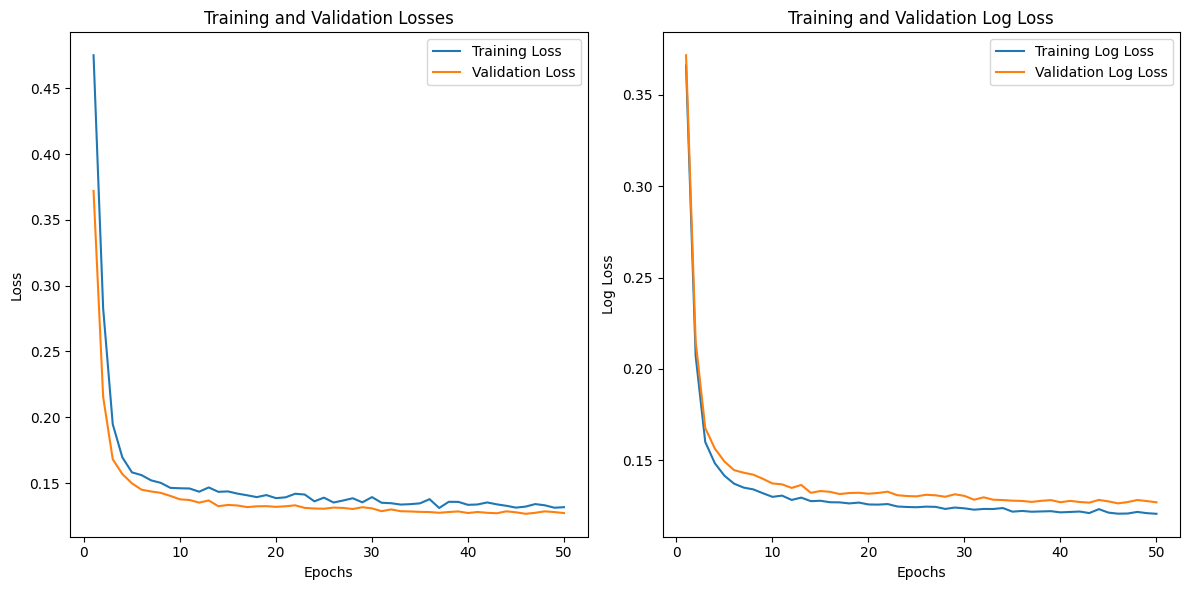

In [23]:
# 2. Evaluate the model on the validation set after training
baseline_val_loss, baseline_val_probs, baseline_val_labels = evaluate_model(baseline_model, val_loader, baseline_criterion)
baseline_val_log_loss = log_loss(baseline_val_labels, baseline_val_probs)  # Calculate validation log loss
print(f"Baseline Test Performance: Log Loss: {baseline_val_log_loss:.4f}, "
      f"AUC: {roc_auc_score(baseline_val_labels, baseline_val_probs):.4f}, "
      f"Brier Score: {brier_score_loss(baseline_val_labels, baseline_val_probs):.4f}")

# 3. Evaluate the model on the test set
baseline_test_loss, baseline_test_probs, baseline_test_labels = evaluate_model(baseline_model, test_loader, baseline_criterion)
baseline_test_log_loss = log_loss(baseline_test_labels, baseline_test_probs)  # Calculate validation log loss
# 4. Print test metrics
print(f"Baseline Test Performance: Log Loss: {baseline_test_log_loss:.4f}, "
      f"AUC: {roc_auc_score(baseline_test_labels, baseline_test_probs):.4f}, "
      f"Brier Score: {brier_score_loss(baseline_test_labels, baseline_test_probs):.4f}")

# 5. Plot losses
plot_losses(baseline_train_losses, baseline_val_losses, baseline_train_log_losses, baseline_val_log_losses, num_epochs=50)

### 3. Hyperparameter Selection

In [25]:
# Ensure that X_train is defined, and then set input_size
input_size = X_train.shape[1]  # Get the number of features from X_train

# Call hyperparameter optimization with verbose output
print("=== Hyperparameter Optimization ===")
study = hyperparameter_optimization(train_loader, val_loader, input_size, num_epochs=20, verbose=False)  # Set verbose to False
print("Best trial:", study.best_trial)
print("Best params:", study.best_trial.params)


[I 2024-10-07 13:43:44,889] A new study created in memory with name: no-name-086693f9-848a-4e9c-b1cb-be46a685b5a8


=== Hyperparameter Optimization ===


[I 2024-10-07 13:43:58,130] Trial 0 finished with value: 0.133190597920883 and parameters: {'n_units1': 68, 'n_units2': 91, 'dropout_rate': 0.31036986611005696, 'lr': 2.602806544632688e-05, 'weight_decay': 1.9739706343424385e-05}. Best is trial 0 with value: 0.133190597920883.


Trial 1: Validation Loss: 0.1332


[I 2024-10-07 13:44:11,502] Trial 1 finished with value: 0.12486260337073629 and parameters: {'n_units1': 178, 'n_units2': 89, 'dropout_rate': 0.4159586576089706, 'lr': 0.00010699568410897849, 'weight_decay': 0.00025779832361047864}. Best is trial 1 with value: 0.12486260337073629.


Trial 2: Validation Loss: 0.1249


[I 2024-10-07 13:44:24,471] Trial 2 finished with value: 0.13491571156716928 and parameters: {'n_units1': 118, 'n_units2': 58, 'dropout_rate': 0.32888468346855504, 'lr': 4.039047631158206e-05, 'weight_decay': 8.483604201009477e-05}. Best is trial 1 with value: 0.12486260337073629.


Trial 3: Validation Loss: 0.1349


[I 2024-10-07 13:44:37,608] Trial 3 finished with value: 0.13590628920895298 and parameters: {'n_units1': 186, 'n_units2': 48, 'dropout_rate': 0.37894001403257915, 'lr': 3.180516802241639e-05, 'weight_decay': 1.3671971580357891e-05}. Best is trial 1 with value: 0.12486260337073629.


Trial 4: Validation Loss: 0.1359


[I 2024-10-07 13:44:51,367] Trial 4 finished with value: 0.12895076285775114 and parameters: {'n_units1': 152, 'n_units2': 126, 'dropout_rate': 0.3975637416520932, 'lr': 0.0009475628945596999, 'weight_decay': 9.526108719718389e-05}. Best is trial 1 with value: 0.12486260337073629.


Trial 5: Validation Loss: 0.1290


[I 2024-10-07 13:45:05,577] Trial 5 finished with value: 0.12311861002590598 and parameters: {'n_units1': 244, 'n_units2': 30, 'dropout_rate': 0.20392577711518997, 'lr': 0.0005497362721273788, 'weight_decay': 4.774705221896839e-06}. Best is trial 5 with value: 0.12311861002590598.


Trial 6: Validation Loss: 0.1231


[I 2024-10-07 13:45:21,211] Trial 6 finished with value: 0.12480102175982986 and parameters: {'n_units1': 246, 'n_units2': 36, 'dropout_rate': 0.4355394992984868, 'lr': 0.0004974943519689848, 'weight_decay': 0.00019998676620463883}. Best is trial 5 with value: 0.12311861002590598.


Trial 7: Validation Loss: 0.1248


[I 2024-10-07 13:45:35,980] Trial 7 finished with value: 0.12669857794918665 and parameters: {'n_units1': 64, 'n_units2': 120, 'dropout_rate': 0.47029679573469046, 'lr': 0.0020781868626133003, 'weight_decay': 0.0006537721357277096}. Best is trial 5 with value: 0.12311861002590598.


Trial 8: Validation Loss: 0.1267


[I 2024-10-07 13:45:50,373] Trial 8 finished with value: 0.1471434714227188 and parameters: {'n_units1': 89, 'n_units2': 39, 'dropout_rate': 0.38944056282489325, 'lr': 2.172105941604573e-05, 'weight_decay': 0.00019403218233624527}. Best is trial 5 with value: 0.12311861002590598.


Trial 9: Validation Loss: 0.1471


[I 2024-10-07 13:46:04,535] Trial 9 finished with value: 0.1252175758161196 and parameters: {'n_units1': 133, 'n_units2': 86, 'dropout_rate': 0.4195872801085343, 'lr': 0.0001695441688591153, 'weight_decay': 1.8320024455768818e-05}. Best is trial 5 with value: 0.12311861002590598.


Trial 10: Validation Loss: 0.1252


[I 2024-10-07 13:46:18,516] Trial 10 finished with value: 0.12261184057811411 and parameters: {'n_units1': 253, 'n_units2': 20, 'dropout_rate': 0.20675205941553246, 'lr': 0.008624293269371504, 'weight_decay': 1.5494826306523986e-06}. Best is trial 10 with value: 0.12261184057811411.


Trial 11: Validation Loss: 0.1226


[I 2024-10-07 13:46:32,303] Trial 11 finished with value: 0.12701974082283857 and parameters: {'n_units1': 256, 'n_units2': 17, 'dropout_rate': 0.20145539475792237, 'lr': 0.00912383667224547, 'weight_decay': 1.533118616914585e-06}. Best is trial 10 with value: 0.12261184057811411.


Trial 12: Validation Loss: 0.1270


[I 2024-10-07 13:46:49,331] Trial 12 finished with value: 0.12535324758145866 and parameters: {'n_units1': 217, 'n_units2': 24, 'dropout_rate': 0.20349457157304243, 'lr': 0.007154742348910218, 'weight_decay': 1.1906493749137582e-06}. Best is trial 10 with value: 0.12261184057811411.


Trial 13: Validation Loss: 0.1254


[I 2024-10-07 13:47:04,065] Trial 13 finished with value: 0.12367555637185167 and parameters: {'n_units1': 220, 'n_units2': 62, 'dropout_rate': 0.26319865614793747, 'lr': 0.002491710024254411, 'weight_decay': 4.603657394738965e-06}. Best is trial 10 with value: 0.12261184057811411.


Trial 14: Validation Loss: 0.1237


[I 2024-10-07 13:47:18,459] Trial 14 finished with value: 0.124327351043864 and parameters: {'n_units1': 226, 'n_units2': 31, 'dropout_rate': 0.27873851080731643, 'lr': 0.002971412071796654, 'weight_decay': 4.31925847973713e-06}. Best is trial 10 with value: 0.12261184057811411.


Trial 15: Validation Loss: 0.1243


[I 2024-10-07 13:47:32,875] Trial 15 finished with value: 0.12340124516588885 and parameters: {'n_units1': 203, 'n_units2': 16, 'dropout_rate': 0.24021885942967375, 'lr': 0.0006076458106848094, 'weight_decay': 4.226262652615274e-06}. Best is trial 10 with value: 0.12261184057811411.


Trial 16: Validation Loss: 0.1234


[I 2024-10-07 13:47:48,305] Trial 16 finished with value: 0.12832264216934763 and parameters: {'n_units1': 239, 'n_units2': 49, 'dropout_rate': 0.23919138669484252, 'lr': 0.00011640831222391542, 'weight_decay': 2.407325676595501e-06}. Best is trial 10 with value: 0.12261184057811411.


Trial 17: Validation Loss: 0.1283


[I 2024-10-07 13:48:03,173] Trial 17 finished with value: 0.12414786813826095 and parameters: {'n_units1': 201, 'n_units2': 66, 'dropout_rate': 0.29474061069739865, 'lr': 0.0012894903326223946, 'weight_decay': 7.280388620758339e-06}. Best is trial 10 with value: 0.12261184057811411.


Trial 18: Validation Loss: 0.1241


[I 2024-10-07 13:48:18,530] Trial 18 finished with value: 0.11983274057870957 and parameters: {'n_units1': 256, 'n_units2': 76, 'dropout_rate': 0.23620523856586761, 'lr': 0.000322403252571378, 'weight_decay': 4.5923398907699896e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 19: Validation Loss: 0.1198


[I 2024-10-07 13:48:33,795] Trial 19 finished with value: 0.125443789926244 and parameters: {'n_units1': 165, 'n_units2': 106, 'dropout_rate': 0.3526727427003347, 'lr': 0.0002618845949020766, 'weight_decay': 4.3378431880061096e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 20: Validation Loss: 0.1254


[I 2024-10-07 13:48:51,070] Trial 20 finished with value: 0.1255631288740693 and parameters: {'n_units1': 200, 'n_units2': 77, 'dropout_rate': 0.2552239470744278, 'lr': 0.0048703975674742606, 'weight_decay': 4.0766285560940084e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 21: Validation Loss: 0.1256


[I 2024-10-07 13:49:06,654] Trial 21 finished with value: 0.12032171369689267 and parameters: {'n_units1': 255, 'n_units2': 74, 'dropout_rate': 0.2246836391648962, 'lr': 0.0003692093516625763, 'weight_decay': 9.563043645765861e-06}. Best is trial 18 with value: 0.11983274057870957.


Trial 22: Validation Loss: 0.1203


[I 2024-10-07 13:49:22,400] Trial 22 finished with value: 0.12633637736846762 and parameters: {'n_units1': 254, 'n_units2': 79, 'dropout_rate': 0.23072249772630576, 'lr': 8.051147856227873e-05, 'weight_decay': 1.0790402211240894e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 23: Validation Loss: 0.1263


[I 2024-10-07 13:49:37,699] Trial 23 finished with value: 0.13821367556002082 and parameters: {'n_units1': 233, 'n_units2': 101, 'dropout_rate': 0.22770860377471877, 'lr': 1.0331469454773722e-05, 'weight_decay': 2.3491058196825943e-06}. Best is trial 18 with value: 0.11983274057870957.


Trial 24: Validation Loss: 0.1382


[I 2024-10-07 13:49:53,175] Trial 24 finished with value: 0.1241980811263003 and parameters: {'n_units1': 216, 'n_units2': 72, 'dropout_rate': 0.2849151355734669, 'lr': 0.00029160057075121055, 'weight_decay': 2.9141073756828557e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 25: Validation Loss: 0.1242


[I 2024-10-07 13:50:08,716] Trial 25 finished with value: 0.12691605650797122 and parameters: {'n_units1': 256, 'n_units2': 53, 'dropout_rate': 0.26006643386884926, 'lr': 0.001399849990156574, 'weight_decay': 7.942920722053007e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 26: Validation Loss: 0.1269


[I 2024-10-07 13:50:23,922] Trial 26 finished with value: 0.12741682952860506 and parameters: {'n_units1': 232, 'n_units2': 69, 'dropout_rate': 0.22370592981643575, 'lr': 0.00017667581411677608, 'weight_decay': 8.807350024471186e-06}. Best is trial 18 with value: 0.11983274057870957.


Trial 27: Validation Loss: 0.1274


[I 2024-10-07 13:50:39,896] Trial 27 finished with value: 0.12707946907456327 and parameters: {'n_units1': 238, 'n_units2': 99, 'dropout_rate': 0.31506390461568423, 'lr': 5.959439811504593e-05, 'weight_decay': 2.3762096442825613e-06}. Best is trial 18 with value: 0.11983274057870957.


Trial 28: Validation Loss: 0.1271


[I 2024-10-07 13:50:55,236] Trial 28 finished with value: 0.12819588140743535 and parameters: {'n_units1': 208, 'n_units2': 81, 'dropout_rate': 0.3484453791233829, 'lr': 0.004296584933247349, 'weight_decay': 2.714031968634996e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 29: Validation Loss: 0.1282


[I 2024-10-07 13:51:10,539] Trial 29 finished with value: 0.12246781222340537 and parameters: {'n_units1': 94, 'n_units2': 96, 'dropout_rate': 0.27009465743465083, 'lr': 0.0007545680649004513, 'weight_decay': 1.7776426604538615e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 30: Validation Loss: 0.1225


[I 2024-10-07 13:51:25,813] Trial 30 finished with value: 0.12259353322953713 and parameters: {'n_units1': 90, 'n_units2': 113, 'dropout_rate': 0.3038691807763627, 'lr': 0.00041326124156233426, 'weight_decay': 1.7983680651177592e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 31: Validation Loss: 0.1226


[I 2024-10-07 13:51:41,303] Trial 31 finished with value: 0.1270209790003009 and parameters: {'n_units1': 92, 'n_units2': 109, 'dropout_rate': 0.3049954389804315, 'lr': 0.00042384989958348275, 'weight_decay': 1.622298885618978e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 32: Validation Loss: 0.1270


[I 2024-10-07 13:51:56,219] Trial 32 finished with value: 0.12228726908201125 and parameters: {'n_units1': 91, 'n_units2': 93, 'dropout_rate': 0.2786916357515586, 'lr': 0.0009505160922102252, 'weight_decay': 4.743020490876012e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 33: Validation Loss: 0.1223


[I 2024-10-07 13:52:11,763] Trial 33 finished with value: 0.12700906666677172 and parameters: {'n_units1': 116, 'n_units2': 94, 'dropout_rate': 0.27566230402694475, 'lr': 0.0008951246138244247, 'weight_decay': 5.636233031566274e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 34: Validation Loss: 0.1270


[I 2024-10-07 13:52:26,567] Trial 34 finished with value: 0.12563257399128705 and parameters: {'n_units1': 78, 'n_units2': 90, 'dropout_rate': 0.24858389863217792, 'lr': 0.0008504628975738822, 'weight_decay': 0.00010760219248413516}. Best is trial 18 with value: 0.11983274057870957.


Trial 35: Validation Loss: 0.1256


[I 2024-10-07 13:52:41,262] Trial 35 finished with value: 0.12458056336859377 and parameters: {'n_units1': 120, 'n_units2': 85, 'dropout_rate': 0.3303390969654011, 'lr': 0.00022119835494196545, 'weight_decay': 2.4592721963265356e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 36: Validation Loss: 0.1246


[I 2024-10-07 13:52:56,122] Trial 36 finished with value: 0.12015359232701907 and parameters: {'n_units1': 147, 'n_units2': 96, 'dropout_rate': 0.2657484898413539, 'lr': 0.001651824496171356, 'weight_decay': 5.982881199770693e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 37: Validation Loss: 0.1202


[I 2024-10-07 13:53:11,012] Trial 37 finished with value: 0.12465524807935807 and parameters: {'n_units1': 153, 'n_units2': 75, 'dropout_rate': 0.22171668636936376, 'lr': 0.0014486282193523121, 'weight_decay': 6.37693190538003e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 38: Validation Loss: 0.1247


[I 2024-10-07 13:53:26,181] Trial 38 finished with value: 0.12190602216415289 and parameters: {'n_units1': 182, 'n_units2': 59, 'dropout_rate': 0.32941585633590315, 'lr': 0.0018186821420963044, 'weight_decay': 0.00014088719444619295}. Best is trial 18 with value: 0.11983274057870957.


Trial 39: Validation Loss: 0.1219


[I 2024-10-07 13:53:41,167] Trial 39 finished with value: 0.12548409206111258 and parameters: {'n_units1': 185, 'n_units2': 58, 'dropout_rate': 0.49993360192165237, 'lr': 0.0017151203705853657, 'weight_decay': 0.00041611155361577024}. Best is trial 18 with value: 0.11983274057870957.


Trial 40: Validation Loss: 0.1255


[I 2024-10-07 13:53:55,808] Trial 40 finished with value: 0.1243483338414169 and parameters: {'n_units1': 168, 'n_units2': 40, 'dropout_rate': 0.3652532412350746, 'lr': 0.003554331928502836, 'weight_decay': 0.00013975172895883912}. Best is trial 18 with value: 0.11983274057870957.


Trial 41: Validation Loss: 0.1243


[I 2024-10-07 13:54:11,294] Trial 41 finished with value: 0.12463326257903401 and parameters: {'n_units1': 138, 'n_units2': 82, 'dropout_rate': 0.32845832110793555, 'lr': 0.0003614584836353829, 'weight_decay': 0.00013829782862753986}. Best is trial 18 with value: 0.11983274057870957.


Trial 42: Validation Loss: 0.1246


[I 2024-10-07 13:54:27,387] Trial 42 finished with value: 0.12480940789711184 and parameters: {'n_units1': 105, 'n_units2': 64, 'dropout_rate': 0.2469176898673105, 'lr': 0.000635148536162539, 'weight_decay': 0.00035209911952483044}. Best is trial 18 with value: 0.11983274057870957.


Trial 43: Validation Loss: 0.1248


[I 2024-10-07 13:54:42,479] Trial 43 finished with value: 0.12270451971307034 and parameters: {'n_units1': 139, 'n_units2': 71, 'dropout_rate': 0.3191996909353499, 'lr': 0.0010684417588688831, 'weight_decay': 4.4014664139930126e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 44: Validation Loss: 0.1227


[I 2024-10-07 13:54:57,982] Trial 44 finished with value: 0.12124285886927348 and parameters: {'n_units1': 73, 'n_units2': 91, 'dropout_rate': 0.21830377710780824, 'lr': 0.0020253416793998523, 'weight_decay': 6.843522410061416e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 45: Validation Loss: 0.1212


[I 2024-10-07 13:55:17,748] Trial 45 finished with value: 0.1267653919574691 and parameters: {'n_units1': 175, 'n_units2': 56, 'dropout_rate': 0.2316102393487067, 'lr': 0.002056472492650085, 'weight_decay': 0.00022799337417543327}. Best is trial 18 with value: 0.11983274057870957.


Trial 46: Validation Loss: 0.1268


[I 2024-10-07 13:55:34,537] Trial 46 finished with value: 0.12682597698961817 and parameters: {'n_units1': 151, 'n_units2': 87, 'dropout_rate': 0.21364095421223545, 'lr': 0.002485523186485977, 'weight_decay': 7.651788473952266e-05}. Best is trial 18 with value: 0.11983274057870957.


Trial 47: Validation Loss: 0.1268


[I 2024-10-07 13:55:51,458] Trial 47 finished with value: 0.12575038749633766 and parameters: {'n_units1': 75, 'n_units2': 125, 'dropout_rate': 0.21340123439147676, 'lr': 0.0001527032290495895, 'weight_decay': 0.00011592759069507845}. Best is trial 18 with value: 0.11983274057870957.


Trial 48: Validation Loss: 0.1258


[I 2024-10-07 13:56:07,062] Trial 48 finished with value: 0.13592333829984432 and parameters: {'n_units1': 245, 'n_units2': 45, 'dropout_rate': 0.4145326520072241, 'lr': 0.006457140641570911, 'weight_decay': 0.00018055637535978252}. Best is trial 18 with value: 0.11983274057870957.


Trial 49: Validation Loss: 0.1359


[I 2024-10-07 13:56:24,774] Trial 49 finished with value: 0.12959136697577267 and parameters: {'n_units1': 183, 'n_units2': 103, 'dropout_rate': 0.29451200171853265, 'lr': 0.0031026355317220313, 'weight_decay': 0.0003173682835395536}. Best is trial 18 with value: 0.11983274057870957.


Trial 50: Validation Loss: 0.1296
Best trial: FrozenTrial(number=18, state=TrialState.COMPLETE, values=[0.11983274057870957], datetime_start=datetime.datetime(2024, 10, 7, 13, 48, 3, 174305), datetime_complete=datetime.datetime(2024, 10, 7, 13, 48, 18, 530194), params={'n_units1': 256, 'n_units2': 76, 'dropout_rate': 0.23620523856586761, 'lr': 0.000322403252571378, 'weight_decay': 4.5923398907699896e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_units1': IntDistribution(high=256, log=False, low=64, step=1), 'n_units2': IntDistribution(high=128, log=False, low=16, step=1), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'lr': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-06, step=None)}, trial_id=18, value=None)
Best params: {'n_units1': 256, 'n_units2': 76, 'dropout_rate': 0.23620523856586761, 'lr': 0.000322403252571378, 'weight_decay': 4.592339890

### 4. Evaluate the model with best parameters

In [145]:
from sklearn.utils.class_weight import compute_class_weight

In [149]:
# Assuming y_train is a NumPy array or a Pandas Series
print("Unique classes in y_train:", np.unique(y_train))


Unique classes in y_train: [0. 1.]


In [152]:
# 2. Create and train the model with the best hyperparameters
print("=== Training with Best Hyperparameters ===")
best_params = study.best_trial.params

best_n1 = 256 #best_params["n_units1"]         # 256
best_n2 = 64 #best_params["n_units2"]         # 76
best_dropout = 0.5 #best_params["dropout_rate"] # 0.23620523856586761
best_lr = 0.0001 #best_params["lr"]               #0.000322403252571378
best_weight = 1e-3 #best_params["weight_decay"] #4.5923398907699896e-05

# Create the model with the best hyperparameters
best_model = create_model(
    input_size=X_train.shape[1],        # Number of features in the input
    n_units1=best_n1,   # 256
    n_units2=best_n2,   # 76
    dropout_rate=best_dropout # 0.23620523
)

# Define the optimizer and criterion
best_optimizer = optim.Adam(best_model.parameters(), lr=best_lr, weight_decay=best_weight)
criterion = nn.BCEWithLogitsLoss()

# Train the model and obtain training/validation losses
best_train_losses, best_train_log_losses, best_val_losses, best_val_log_losses = train_model(
    best_model, train_loader, val_loader, criterion, best_optimizer, num_epochs=100, verbose=True
)


=== Training with Best Hyperparameters ===
Epoch [1/100] - Train Loss: 0.4993, Train Log Loss: 0.2546, Validation Log Loss: 0.2565
Epoch [2/100] - Train Loss: 0.1821, Train Log Loss: 0.1483, Validation Log Loss: 0.1566
Epoch [3/100] - Train Loss: 0.1482, Train Log Loss: 0.1350, Validation Log Loss: 0.1422
Epoch [4/100] - Train Loss: 0.1423, Train Log Loss: 0.1303, Validation Log Loss: 0.1403
Epoch [5/100] - Train Loss: 0.1402, Train Log Loss: 0.1294, Validation Log Loss: 0.1373
Epoch [6/100] - Train Loss: 0.1367, Train Log Loss: 0.1279, Validation Log Loss: 0.1349
Epoch [7/100] - Train Loss: 0.1376, Train Log Loss: 0.1267, Validation Log Loss: 0.1349
Epoch [8/100] - Train Loss: 0.1354, Train Log Loss: 0.1272, Validation Log Loss: 0.1341
Epoch [9/100] - Train Loss: 0.1342, Train Log Loss: 0.1245, Validation Log Loss: 0.1318
Epoch [10/100] - Train Loss: 0.1358, Train Log Loss: 0.1237, Validation Log Loss: 0.1306
Epoch [11/100] - Train Loss: 0.1323, Train Log Loss: 0.1234, Validation Log 

Best Vali Performance: Log Loss: 0.1195, AUC: 0.8696, Brier Score: 0.0310
Best Test Performance: Log Loss: 0.1152, AUC: 0.8870, Brier Score: 0.0306


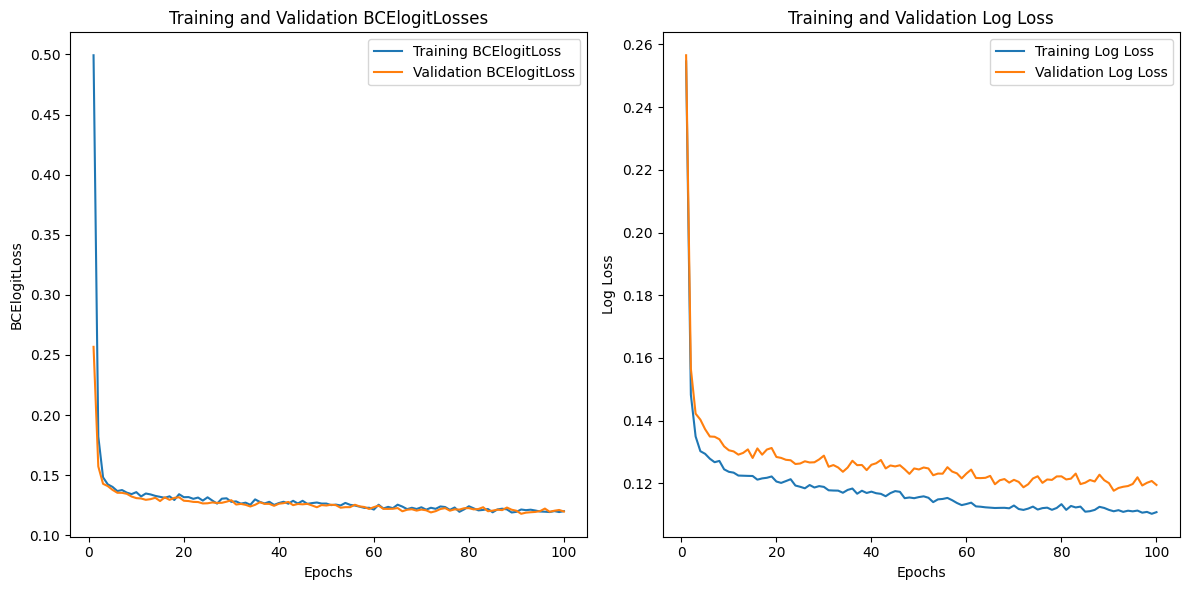

In [153]:
# 2. Evaluate the model on the validation set after training
best_val_loss, best_val_probs, best_val_labels = evaluate_model(best_model, val_loader, criterion)
best_val_log_loss = log_loss(best_val_labels, best_val_probs)  # Calculate validation log loss
print(f"Best Vali Performance: Log Loss: {best_val_log_loss:.4f}, "
      f"AUC: {roc_auc_score(best_val_labels, best_val_probs):.4f}, "
      f"Brier Score: {brier_score_loss(best_val_labels, best_val_probs):.4f}")

# 3. Evaluate the model on the test set
best_test_loss, best_test_probs, best_test_labels = evaluate_model(best_model, test_loader, criterion)
best_test_log_loss = log_loss(best_test_labels, best_test_probs)  # Calculate validation log loss
# 4. Print test metrics
print(f"Best Test Performance: Log Loss: {best_test_log_loss:.4f}, "
      f"AUC: {roc_auc_score(best_test_labels, best_test_probs):.4f}, "
      f"Brier Score: {brier_score_loss(best_test_labels, best_test_probs):.4f}")

# 5. Plot losses
plot_losses(best_train_losses, best_val_losses, best_train_log_losses, best_val_log_losses, num_epochs=50)

### 5. Update the weights and biases in the model, and evaluate the model performance

In [154]:
# 3. Update Weights and Biases with best hyperparameters
print("=== Retraining with Best Hyperparameters with updating weights and biases ===")
best_n1 = 256 #best_params["n_units1"]         # 256
best_n2 = 64 #best_params["n_units2"]         # 76
best_dropout = 0.5 #best_params["dropout_rate"] # 0.23620523856586761
best_lr = 0.0001 #best_params["lr"]               #0.000322403252571378
best_weight = 1e-3 #best_params["weight_decay"] #4.5923398907699896e-05

update_model, update_train_losses, update_train_log_losses, update_val_losses, update_val_log_losses = update_weights_and_biases(
    best_n1, best_n2, best_dropout, best_lr, best_weight, train_loader, val_loader, input_size, num_epochs = 100  # Include input_size here
)
# 4. Evaluate updated model on validation set
updated_val_loss, updated_val_probs, updated_val_labels = evaluate_model(update_model, val_loader, criterion)
updated_val_log_loss = log_loss(updated_val_labels, updated_val_probs)  # Calculate validation log loss

# 5. Evaluate updated model on test set
updated_test_loss, updated_test_probs, updated_test_labels = evaluate_model(update_model, test_loader, criterion)
updated_test_log_loss = log_loss(updated_test_labels, updated_test_probs)  # Calculate validation log loss

=== Retraining with Best Hyperparameters with updating weights and biases ===
Epoch [1/100] - Train Loss: 0.4395, Train Log Loss: 0.2264, Validation Log Loss: 0.2310
Epoch [2/100] - Train Loss: 0.1818, Train Log Loss: 0.1497, Validation Log Loss: 0.1594
Epoch [3/100] - Train Loss: 0.1522, Train Log Loss: 0.1365, Validation Log Loss: 0.1439
Epoch [4/100] - Train Loss: 0.1493, Train Log Loss: 0.1325, Validation Log Loss: 0.1395
Epoch [5/100] - Train Loss: 0.1388, Train Log Loss: 0.1292, Validation Log Loss: 0.1375
Epoch [6/100] - Train Loss: 0.1384, Train Log Loss: 0.1280, Validation Log Loss: 0.1370
Epoch [7/100] - Train Loss: 0.1384, Train Log Loss: 0.1260, Validation Log Loss: 0.1316
Epoch [8/100] - Train Loss: 0.1380, Train Log Loss: 0.1255, Validation Log Loss: 0.1307
Epoch [9/100] - Train Loss: 0.1365, Train Log Loss: 0.1245, Validation Log Loss: 0.1315
Epoch [10/100] - Train Loss: 0.1344, Train Log Loss: 0.1235, Validation Log Loss: 0.1302
Epoch [11/100] - Train Loss: 0.1347, Trai

Updated Vali Performance: Log Loss: 0.1207, AUC: 0.8700, Brier Score: 0.0313
Updated Test Performance: Log Loss: 0.1157, AUC: 0.8885, Brier Score: 0.0307


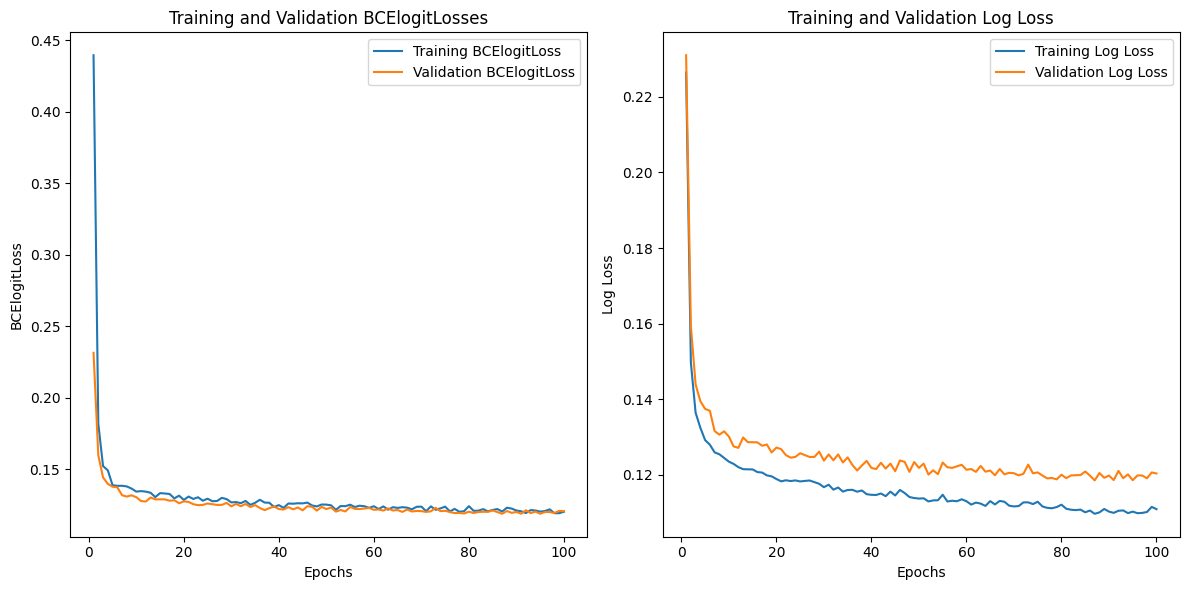

In [155]:
# 6. Print updated test metrics
print(f"Updated Vali Performance: Log Loss: {updated_val_loss:.4f}, "
      f"AUC: {roc_auc_score(updated_val_labels, updated_val_probs):.4f}, "
      f"Brier Score: {brier_score_loss(updated_val_labels, updated_val_probs):.4f}")

print(f"Updated Test Performance: Log Loss: {updated_test_loss:.4f}, "
      f"AUC: {roc_auc_score(updated_test_labels, updated_test_probs):.4f}, "
      f"Brier Score: {brier_score_loss(updated_test_labels, updated_test_probs):.4f}")

# 7. Plot losses for the retrained model
num_epochs = len(update_train_log_losses)
plot_losses(update_train_losses, update_val_losses, update_train_log_losses, update_val_log_losses, num_epochs=num_epochs)

### Make prediction on test dataset

In [156]:
# 1. Evaluate updated model on the test set
print("=== Making Predictions on Test Set ===")
update_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    test_probs = torch.sigmoid(update_model(test_loader.dataset.tensors[0])).cpu().numpy()

=== Making Predictions on Test Set ===


In [157]:
# Replace 'your_file.tsv' with the path to your TSV file
prediction_file = pd.read_csv('/home/scarlett/github/RNAseq-analysis/semi_empirical_simulator/NA12878_testset_error_predicted.tsv', sep='\t')
updated_prediction_file = prediction_file

In [158]:
updated_prediction_file['NN_pred_prob'] = test_probs
updated_prediction_file

,geneID,log10distance_intxn_r2,log10distance_intxn_minMAF,log10distance_intxn_diffMAF,error,d,r2,min_MAF,diff_MAF,lag_MAF,log10_distance,error.1,xgb_pred_prob,log_pred_prob,NN_pred_prob
0,ENSG00000106261,0.001716,0.001716,0.240584,0.0,1.0,0.001,0.0010,0.1402,0.0010,1.716003,0.0,0.404808,0.120879,0.246477
1,ENSG00000182087,0.140864,0.385769,0.122823,0.0,1.0,0.057,0.1561,0.0497,0.1561,2.471292,0.0,0.007712,0.006803,0.013090
2,ENSG00000141127,0.160278,0.410408,1.510983,0.0,0.2,0.033,0.0845,0.3111,0.3956,4.856904,0.0,0.227187,0.269231,0.257153
3,ENSG00000133710,0.004430,0.902770,0.000000,0.0,1.0,0.002,0.4076,0.0000,0.4076,2.214844,0.0,0.005385,0.000000,0.007731
4,ENSG00000166535,0.180088,0.202600,0.763522,0.0,1.0,0.068,0.0765,0.2883,0.0765,2.648360,0.0,0.010459,0.033333,0.019575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4360,ENSG00000162433,1.886491,0.703284,0.000000,0.0,1.0,1.000,0.3728,0.0000,0.3728,1.886491,0.0,0.001524,0.000000,0.001866
4361,ENSG00000120457,1.677899,0.408115,0.152462,0.0,1.0,0.613,0.1491,0.0557,0.1491,2.737193,0.0,0.002925,0.006803,0.007219
4362,ENSG00000101557,1.086485,0.234775,1.117663,0.0,1.0,0.230,0.0497,0.2366,0.2863,4.723850,0.0,0.099856,0.203125,0.081677
4363,ENSG00000167323,0.109414,0.088122,1.190540,0.0,1.0,0.037,0.0298,0.4026,0.4324,2.957128,0.0,0.027794,0.120879,0.030915


In [159]:
updated_prediction_file.to_csv('/home/scarlett/github/RNAseq-analysis/semi_empirical_simulator/NA12878_testset_error_predicted.tsv', sep='\t', index=False)

In [160]:
import seaborn as sns
def plot_predicted_prob_distribution(test_output, predicted_col, true_error_col='error', maf_col='min_MAF'):
    """
    Plot 3 distribution plots in one row:
    1. Overall predicted probability distribution.
    2. Predicted probability distribution for subset where min_MAF < 0.002.
    3. Predicted probability distribution for the complement subset where min_EUR_MAF >= 0.002.
    
    Args:
        test_output (pd.DataFrame): The dataframe containing the data.
        predicted_col (str): The column name for predicted error probability.
        true_error_col (str): The column name for the true error rate.
        maf_col (str): The column name for min_EUR_MAF. Default is 'min_EUR_MAF'.
    """
    # Create a figure with 3 subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Calculate the overall average true error rate
    avg_true_error_rate = test_output[true_error_col].mean()

    # 1st plot: Overall distribution of predicted probabilities with histogram and density
    axes[0].hist(test_output[predicted_col], bins=30, density=True, alpha=0.6, color='b', label='Histogram')
    sns.kdeplot(test_output[predicted_col], ax=axes[0], color='orange', label='Density')
    axes[0].axvline(avg_true_error_rate, color='red', linestyle='--', 
                    label=f'Average True Error Rate: {avg_true_error_rate:.5f}')
    axes[0].axvline(test_output[predicted_col].mean(), color='green', linestyle='--', 
                    label=f'Average Predicted Error Rate: {test_output[predicted_col].mean():.5f}')
    axes[0].set_xlabel('Predicted Probability of Error')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Overall Predicted Probability Distribution')
    axes[0].legend(loc='upper right')  # Force legend to top right corner

    # 2nd plot: Distribution for subset where min_EUR_MAF < 0.002
    subset = test_output[test_output[maf_col] <= 0.002]
    avg_true_error_rate = subset[true_error_col].mean()
    axes[1].hist(subset[predicted_col], bins=30, density=True, alpha=0.6, color='b', label='Histogram')
    sns.kdeplot(subset[predicted_col], ax=axes[1], color='orange', label='Density')
    axes[1].axvline(avg_true_error_rate, color='red', linestyle='--', 
                    label=f'Average True Error Rate: {avg_true_error_rate:.5f}')
    axes[1].axvline(subset[predicted_col].mean(), color='green', linestyle='--', 
                    label=f'Subset Predicted Error Rate: {subset[predicted_col].mean():.5f}')
    axes[1].set_xlabel('Predicted Probability of Error')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Subset Distribution (min_MAF < 0.002)')
    axes[1].legend(loc='upper right')  # Force legend to top right corner

    # 3rd plot: Distribution for complement subset (min_EUR_MAF >= 0.002)
    complement_subset = test_output[test_output[maf_col] >= 0.002]
    avg_true_error_rate = complement_subset[true_error_col].mean()
    axes[2].hist(complement_subset[predicted_col], bins=30, density=True, alpha=0.6, color='b', label='Histogram')
    sns.kdeplot(complement_subset[predicted_col], ax=axes[2], color='orange', label='Density')
    axes[2].axvline(avg_true_error_rate, color='red', linestyle='--', 
                    label=f'Average True Error Rate: {avg_true_error_rate:.5f}')
    axes[2].axvline(complement_subset[predicted_col].mean(), color='green', linestyle='--', 
                    label=f'Complement Predicted Error Rate: {complement_subset[predicted_col].mean():.5f}')
    axes[2].set_xlabel('Predicted Probability of Error')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Complement Distribution (min_MAF >= 0.002)')
    axes[2].legend(loc='upper right')  # Force legend to top right corner

    # Adjust the layout to prevent overlap
    plt.tight_layout()

    # Show the figure
    plt.show()


/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

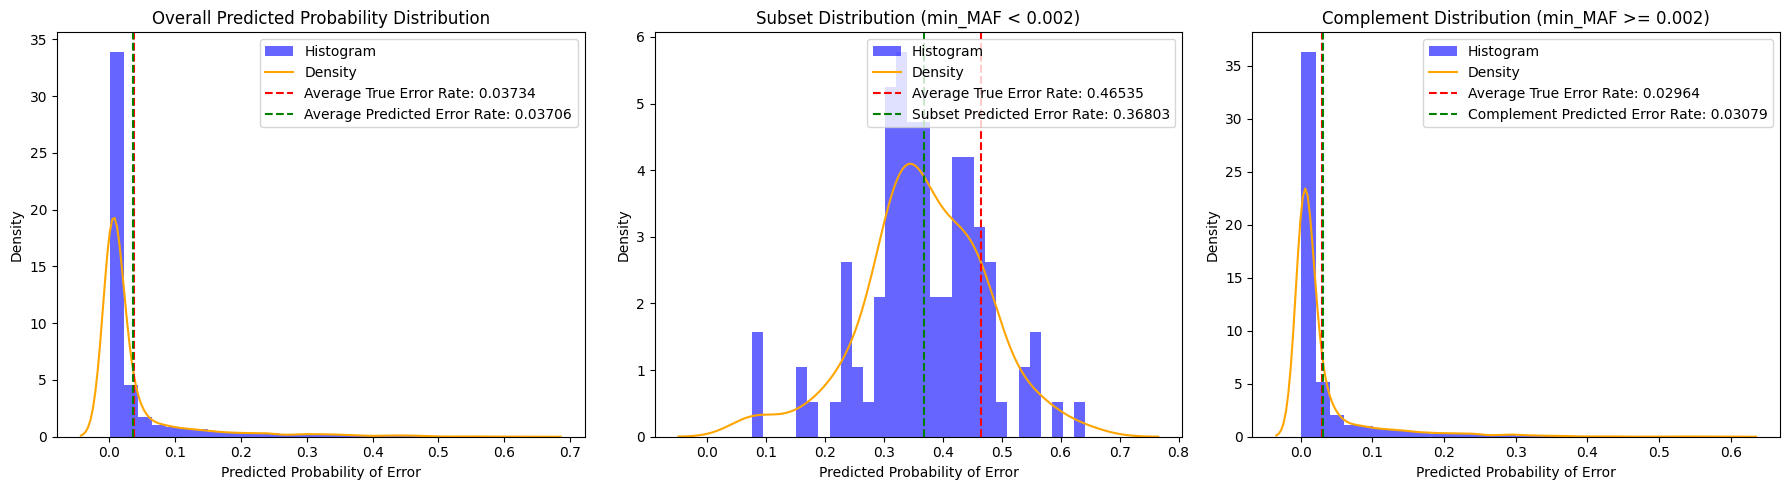

In [161]:
plot_predicted_prob_distribution(updated_prediction_file, predicted_col='xgb_pred_prob')

/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

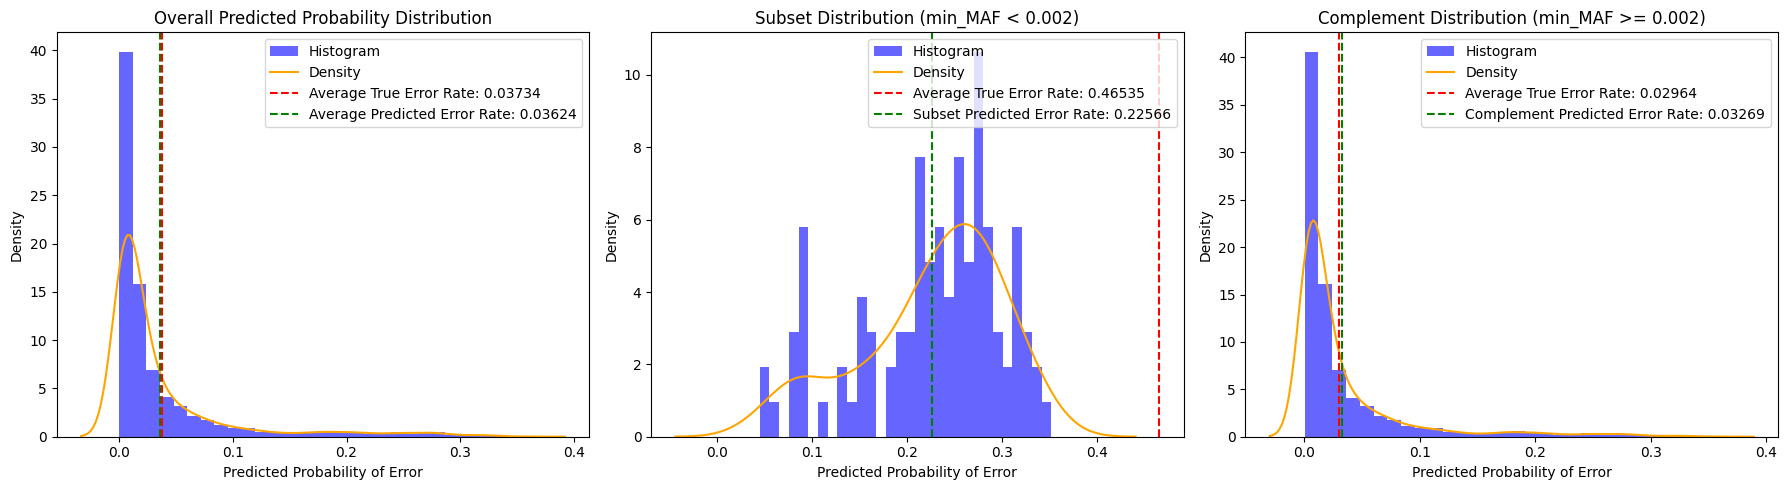

In [162]:
plot_predicted_prob_distribution(updated_prediction_file, predicted_col='NN_pred_prob')

/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

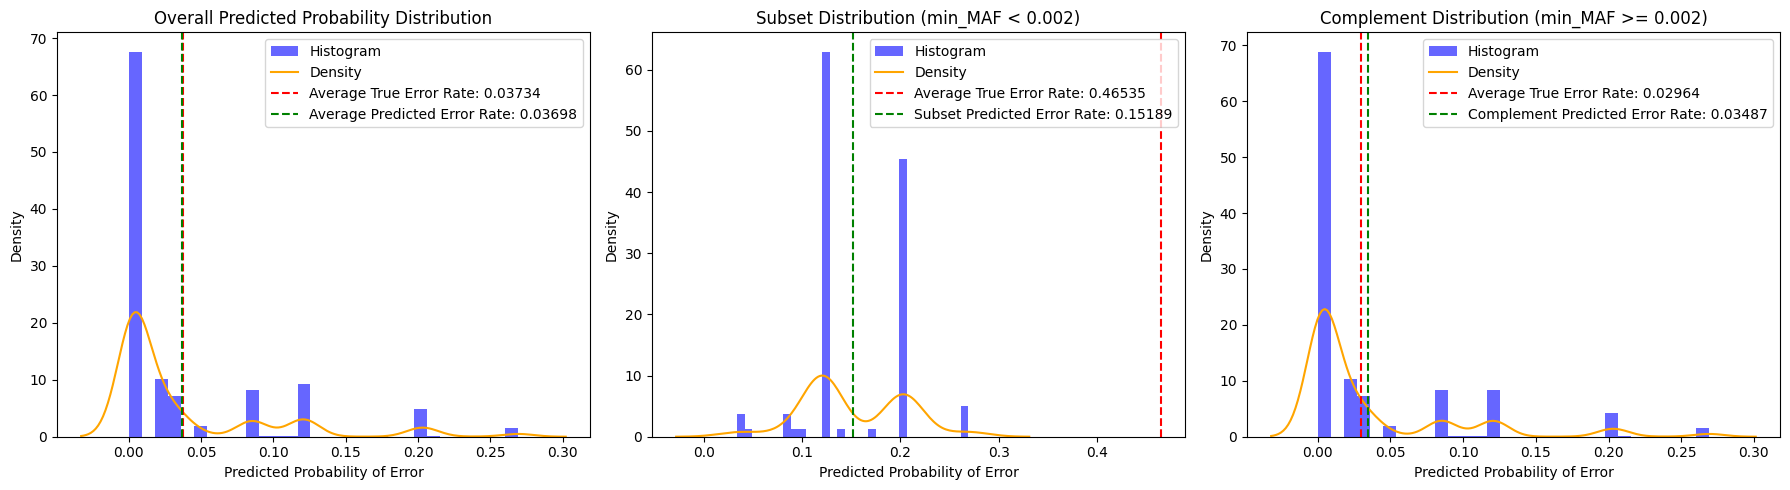

In [163]:
plot_predicted_prob_distribution(updated_prediction_file, predicted_col='log_pred_prob')